In [1]:
import tensorflow as tf
import sonnet as snt

import matplotlib.pyplot as plt

import graph_nets as gn
import pgm

/home/act65/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/act65/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/act65/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
model = pgm.PGM(lambda: pgm.linear_model_fn)

In [3]:
def init_graph(dims, n_edges, n_nodes):
    # random edge pairs: sender - receiver
    with tf.variable_scope('init_graph_test'):
        edges = tf.random_uniform(minval=0, maxval=n_nodes, dtype=tf.int32, shape=[n_edges//2, 2])
        receivers = edges[:, 0]
        senders = edges[:, 1]

        edge_attr = tf.Variable(tf.random_normal([n_edges, dims, dims]))
        graph = {
              "globals": tf.random_normal([dims]),
              "nodes": tf.random_normal([n_nodes, dims]),
              "edges": edge_attr,
              "receivers": tf.concat([edges[:, 0], edges[:, 1]], axis=0),
              "senders": tf.concat([edges[:, 1], edges[:, 0]], axis=0),  # symmetric
          }
        return gn.utils_tf.data_dicts_to_graphs_tuple([graph])

def set_input(x, graph):
    nodes = tf.concat([x + graph.nodes[0, ...], 
                   graph.nodes[1:, ...]], 
                  axis=0)
    return graph.replace(nodes=nodes)    

In [4]:
input_graph = init_graph(dims=2,n_edges=32,n_nodes=3)
x = tf.random_normal([1, 2])
t = 3*x + 1
graph = set_input(x, input_graph)
for _ in range(3):
    graph = model(graph)
    
y = graph.nodes[-1, ...]
loss = tf.reduce_sum(tf.square(t - y))

In [5]:
opt = tf.train.AdamOptimizer(0.01)
gnvs = opt.compute_gradients(loss)
train_step = opt.apply_gradients(gnvs, global_step=tf.train.get_or_create_global_step())

In [6]:
Losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for _ in range(10000):
        L, _ = sess.run([loss, train_step])
        print('\rloss: {}'.format(L), end='', flush=True)
        Losses.append(L)
        
    L, Y, T = sess.run([loss, y, t])

loss: 31.09215545654297

In [7]:
print(L, Y, T)

3.0266893 [ 3.596105  -1.1416367] [[ 4.774403 -2.421599]]


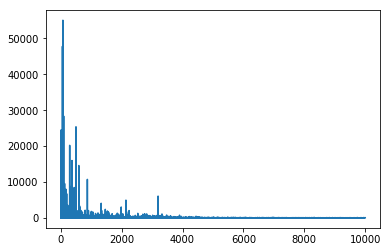

In [8]:
plt.plot(Losses)